In [301]:
import numpy as np
import sys
import os
from pathlib import Path
import itertools
import lib_liblinear.python.liblinearutil as lbl
import matplotlib.pyplot as plt
import scipy.optimize as opt
from PIL import Image 
dir_path = Path.cwd()

print(dir_path)
sys.path.insert(0, dir_path)

/home/nikolaos/Workspaces/AML/Assignment_1_Programming/code


# Part 1

In [346]:
dataPath = os.path.join(dir_path, '../data')
resPath = os.path.join(dir_path, 'results')
letters = 'abcdefghijklmnopqrstuvwxyz'
# Load decode Input
decInputFile = os.path.join(dataPath, 'decode_input.txt')
with open(decInputFile, 'r') as f:
    inData = f.read().splitlines()
    inX = np.asarray(inData[0:12800], dtype = np.float)     # input is 100 letters @ 128 = 12800, or 0-12799. NOTE: Recall Python slice is [).
    inW = np.asarray(inData[12800:16128], dtype = np.float) # wieths are 26 * 128 = 3328, or 12800-16127
    inT = np.asarray(inData[16128:], dtype = np.float)      # The remaing are the transition probs.
print("Done reading! Sizes are X: {}, W:{},T: {}. Total: {}".format(inX.shape, inW.shape, inT.shape, inX.size+inW.size+inT.size))

# Reshape arrays
# Reshape T to 26x26
inT = np.reshape(inT,(26,26)) 
inX = np.reshape(inX, (-1,128))
inW = np.reshape(inW, (128,-1))
featSize = 128
numOfLabels = 26
print("Done reshaping! Sizes now are X: {}, W:{},T: {}".format(inX.shape, inW.shape, inT.shape))

Done reading! Sizes are X: (12800,), W:(3328,),T: (676,). Total: 16804
Done reshaping! Sizes now are X: (100, 128), W:(128, 26),T: (26, 26)


### Part 1.c Decoder Implementation

In [3]:
# Max-Prod algorithm!
def crf_decode_max_prod(seq, w, t):
    """ DESCRIPTION: Max-Prod algorithm. Not used for this assignment. Use max-sum instead!
    """
    # Init
    seqLen  = seq.shape[0]
    dataLen = w.shape[1]
    cMat    = np.zeros((seqLen, dataLen))
    bMat    = np.matmul(seq, w) # this gives the probability of observing each i standalone
    maxIdx  = np.zeros((seqLen, dataLen), dtype = np.int)
    decSeq  = []
    maxObj  = 0
    ci = np.zeros((26,26))
    
    # Get step 0 estimates
    step0    = np.matmul(seq[0,:], w)
    c1 = np.multiply(step0,t)      # the previous node potential x edje potenital for all i->j pairs
    maxIdx[0,:] = np.argmax(c1, axis = 0) #1x26 the max elem indexes
    c1 = c1[maxIdx[0,:],np.arange(c1.shape[1])] #1x26 select the max element, as indexed by maxIdx, for every column
    cMat[0,:] = c1
    print("Input shapes: sequence: {}, weights: {}, T matrix:{}".format(seq.shape,w.shape,t.shape))
    
    # Perform a pass over steps 1-99 or 2-100 in 1-index notation!
    for i in range(1,seqLen):
        fi  = bMat[i,:]              # get likelihood of i observation being any letter as standalone 
        cYi = cMat[i-1,:]            # i-1 step's potential msg to this node i
        cYj = np.multiply(fi, t)     # mul the likelihood of each letter with all transition probs.
        maxIdx[i,:] = np.argmax(cYj, axis = 0) #1x26 the max elem indexes
        cYj = cYj[maxIdx[i,:],np.arange(cYj.shape[1])] #1x26 select the max element, as indexed by maxIdx, for every column
        cYj = np.multiply(cYj, cYi)  # multiply current cYj = g_yj->yi* fj with pervious node's(i-1) msgs to yield the msg node i will wend to i+1
        cMat[i,:] = cYj              # store this node's msg, in order to send it to i+1 on next step!
        #if i == 1:
        #    print(cYj, cYj.shape, fi.shape)
    maxObj = np.max(cYj)             # max objective value is the maximum of the lasp step's messages or potentials Y_end 
    # Backward pass.
    # At each step, the element e at slot i is the label that most likely lead to the lable represented as i.
    # So at i.e if 95,5 = 11, then that means that the most probable letter that leads to f(idx 5) if letter 11 or l (label 11). All indexing is 0 based.
    decSeq     = np.zeros((seqLen,1), dtype = np.int)
    lastMax    = np.argmax(maxIdx[-1,:]) # get the most probable last element. use this to recurse and find the most prob sequence
    decSeq[-1] = lastMax
    for i in range(seqLen-2,-1,-1):
        #print("i is ", i, "decSeq of ", i+1, "is", decSeq[i+1])
        curMax = maxIdx[i,decSeq[i+1]]
        decSeq[i] = curMax
        
    return decSeq, maxObj
    
decSeq,maxObj = crf_decode2(inX, inW, inT)
print(maxObj)

NameError: name 'crf_decode2' is not defined

In [357]:
# Max-Sum algorithm!
def crf_decode(seq, w, t):
    """ DESCRIPTION: Using max-sum algorithm to decode. THis function will use the forward pass to compute
                     the most probable last letter, at place m for a seq of length m. Then using that knowledge
                     it will go backwards at m-1 extracting the character that was most likely to lead to the most probable 
                     character at place m. It will recurcively continue until we have a candidate at place m=0 and return
                     the labels that we are most confident they match the input.
        ARGUMENTS: seq(ndarray): a sequqnce that contains aoiur input data.
    """
    # Init
    seqLen  = seq.shape[0]
    dataLen = w.shape[1]
    cMat    = np.zeros((seqLen, dataLen))
    bMat    = np.matmul(seq, w) # this gives the probability of observing each i standalone
    maxIdx  = np.zeros((seqLen, dataLen), dtype = np.int)
    decSeq  = []
    maxObj  = 0
    ci = np.zeros((26,26))
    
    # Get step 0 estimates
    step0    = np.matmul(seq[0,:], w)
    c1 = np.multiply(step0,t)      # the previous node potential x edje potenital for all i->j pairs
    maxIdx[0,:] = np.argmax(c1, axis = 0) #1x26 the max elem indexes
    c1 = c1[maxIdx[0,:],np.arange(c1.shape[1])] #1x26 select the max element, as indexed by maxIdx, for every column
    cMat[0,:] = 0
    #print("Input shapes: sequence: {}, weights: {}, T matrix:{}".format(seq.shape,w.shape,t.shape))
    
    # Perform a pass over steps 1-99 or 2-100 in 1-index notation!
    for i in range(1,seqLen):
        fi  = bMat[i-1,:].reshape(-1,1)              # get likelihood of i observation being any letter as standalone 
        cYi = cMat[i-1,:].reshape(-1,1)            # i-1 step's potential msg to this node i
        cYj = fi + t + cYi     # mul the likelihood of each letter with all transition probs.
        #if i ==1:
            #print(cYi.shape,cYj.shape)
        maxIdx[i,:] = np.argmax(cYj, axis = 0) #1x26 the max elem indexes
        cYj = cYj[maxIdx[i,:],np.arange(cYj.shape[1])] #1x26 select the max element, as indexed by maxIdx, for every column
        #cYj = np.multiply(cYj, cYi)  # multiply current cYj = g_yj->yi* fj with pervious node's(i-1) msgs to yield the msg node i will wend to i+1
        cMat[i,:] = cYj              # store this node's msg, in order to send it to i+1 on next step!
        #if i == 1:
        #    print(cYj, cYj.shape, fi.shape)
    maxObj = np.max(cYj)             # max objective value is the maximum of the lasp step's messages or potentials Y_end 
    # Backward pass.
    # At each step, the element e at slot i is the label that most likely lead to the lable represented as i.
    # So at i.e if 95,5 = 11, then that means that the most probable letter that leads to f(idx 5) if letter 11 or l (label 11). All indexing is 0 based.
    decSeq     = np.zeros((seqLen,1), dtype = np.int)
    lastMax    = np.argmax(maxIdx[-1,:]) # get the most probable last element. use this to recurse and find the most prob sequence
    decSeq[-1] = lastMax
    for i in range(seqLen-2,-1,-1):
        #print("i is ", i, "decSeq of ", i+1, "is", decSeq[i+1])
        curMax = maxIdx[i,decSeq[i+1]]
        decSeq[i] = curMax
    # Remember that python indexes from 0. Labels are 1-26 so we must add 1 to compensate
    return decSeq+1, maxObj
    
decSeq,maxObj = crf_decode(inX, inW, inT)
print(maxObj)

206.68391391587812


In [ ]:
def write_dec_seq_to_file(seq, resPath, label='decode_output.txt'):
    """ DESCRIPTION: Write the decoded results to file
    """
    # Create results dir if ti does not exists (Python3.2+)
    #resPath = os.path.join(dir_path, 'results')
    os.makedirs(resPath, exist_ok=True) 
    # Form file name and write output
    resFile = os.path.join(resPath, label)
    np.savetxt(resFile, seq.astype(int),fmt='%d')
# ------------------------------------------------------------------    
write_dec_seq_to_file(deqSeq, os.path.join(dir_path, 'results'))

# Part 2
## Towards Gradients: Marginals Computation

#### Load Data for all formats

In [295]:
# Part 3 Benchamrking with SVM!
modelLabels = ['CRF', 'SVM-HMM', 'SVM-MC']
# Define where svm_hmm lib and executables are
libPath = os.path.join(dir_path,'svm_hmm_linux64')
learnerPath = os.path.join(libPath, 'svm_hmm_learn')
testerPath  = os.path.join(libPath, 'svm_hmm_classify')
# data for the hmm svm
svmTrainData = os.path.join(dataPath,'train_struct.txt')
svmTestData = os.path.join(dataPath,'test_struct.txt')
# liblinear svm data
libSVMTrainData = os.path.join(dataPath, 'liblinear_svm_train.txt')
libSVMTestData  = os.path.join(dataPath, 'liblinear_svm_test.txt')
# make a file of true classes if they dont exists, without hte other stuff
sanTrainTruthFile = os.path.join(dataPath, 'sanitizedTrainTruth.txt')
sanTestTruthFile = os.path.join(dataPath, 'sanitizedTestTruth.txt')
# Load the data in CRF readable format
crfTrainFile = os.path.join(dataPath, 'train.txt')
crfTestFile  = os.path.join(dataPath, 'test.txt')

def load_crf_data(trainFile, testFile):
    """ DESCRIPTION: This function will read the files and return the data as numpy arrays, without the additional supporting information
                     which in the provided files arethe first 5 characters describing word indx, letter indx end letter indicator etc.
                     Refer to fields_crf.txt for more info on those
        RETURNS: ndarrays: The numpy arrays containing just the data. Shape is  numOfLetters x 128
    """
    with open(trainFile,'r') as tr, open(testFile,'r') as ts:
        trainD = np.asarray([[int(y) for y in x.split(' ')[5:]] for x in tr.read().splitlines()])
        testD  = np.asarray([[int(y) for y in x.split(' ')[5:]] for x in ts.read().splitlines()])
        
        #print(len(trainD[0]),len(testD[0]))
    return trainD, testD
#-------------------------------------------------------------------
trainD, testD = load_crf_data(crfTrainFile, crfTestFile)

def get_sanitized_labels(inFile, sanTruthFile = None):
    # Load the true classes and word-letter indexex (2nd column of file)
    # Get just the true labels and word indexes for all letters without features and the rest
    if  not os.path.exists(sanTruthFile) or sanTruthFile is None:
        with open(inFile,'r') as o, open(sanTruthFile,'w') as s:
            d =[x.split(' ') for x in o.readlines()]   # split file into a list of lists of tokens
            sanLabel =[x[0] for x in d]                # get all labels. Its the first token of each line
            sanWIdx = [x[1].split(':')[1] for x in d]  # get all word indexes. It is the number after the : of the second token.
            # using list comprehension + zip() 
            # interlist element concatenation 
            sanData = [' '.join((i,j)) for i, j in zip(sanLabel, sanWIdx)]  
            print(sanData[0:30])
            s.write("\n".join(sanData))
            sanData = np.asarray(sanData.split(), dtype = np.int)
            print(sanData[0:30])
    else:
        sanData = np.loadtxt(sanTruthFile, dtype = np.int, delimiter = ' ')
    return sanData
#-------------------------------------------------------------------
sanTrainLabels = get_sanitized_labels(svmTrainData, sanTrainTruthFile)        
sanTestLabels = get_sanitized_labels(svmTestData, sanTestTruthFile)        
#gTruth = np.asarray([x.split(' ')[0] for x in open(sanTruthFile).readlines()]) # keep in mind that readlines retunrs the \n character

#-------------------------------------------------------------------
# transform data strcuture to LIBLINEAR format. Essentially we need to only remove the qid:x part
if not  os.path.exists(libSVMTestData):
    with open(svmTestData,'r') as i, open(libSVMTestData,'w') as o:
        d =[x.split(' ') for x in i.readlines()]   # split file into a list of lists of tokens
        for row in d:
            del row[1]
        #print(d[0:20])
        d = [' '.join(row[0:-1]) for row in d]
        o.write("\n".join(d))
        
if not os.path.exists(libSVMTrainData):
    with open(svmTrainData,'r') as i, open(libSVMTrainData,'w') as o:
        d =[x.split(' ') for x in i.readlines()]   # split file into a list of lists of tokens
        for row in d:
            del row[1]
        d = [' '.join(row[0:-1]) for row in d]
        #print(d[0:20])
        o.write("\n".join(d))    
d = 0
# --------------------------------------------------------------

def extract_word_idxs(inData):
    """ DESCRIPTION: Expects a file that  has a per-line word idx. That is each row is the word idx the letter belongs to.
        ARGUMENTS: inData (ndarray): A numpy array containing the letter-word idxs. Each line is the letter idx in data and the value is
                                     the word it belongs to. So line 0, with value = 1 means letter 0 belongs to word 1.
        RETURNS: wordIdxs(ndarray): A numpy arra 1D, that holds at each location the end limit of that word. So at location i=2, the bvalue v=17
                                    means that word 2 ends at location 17. So when indexing with python's [) ranges, we just use word2 = data[endWord1, 17]
    """
    wordIdxs = np.zeros(inData[-1], dtype=np.int)
    curIdx = 1
    for i, runIdx in enumerate(inData):
        if curIdx != runIdx:
            wordIdxs[curIdx] = i
            curIdx = runIdx
    #print(wordIdxs.shape, wordIdxs[-20:]) 
    return wordIdxs
# ------------------------------------------------------------------
#
def append_label_to_crf_data(trainD, testD, trainL, testL):
    """ DESCRIPTION: This function is needed to append letter and wordwise labels to raw data. optimize.py file provided accesses data in a different 
                     manner, passing only one table for data input, assuming the labels are carried along. As such, we need to concat the 2 matrices.
    
    """
    labTrainD = np.append(trainL, trainD, axis = 1) 
    labTestD = np.append(testL, testD, axis = 1) 
    return labTrainD, labTestD
#Extract the word Indexes.
wordIdxs = extract_word_idxs(sanTrainLabels[:,1])
wordTestIdxs = extract_word_idxs(sanTestLabels[:,1])

In [261]:
inW.shape

(128, 26)

## Compute log Marginals and log p(Y|X)

In [332]:
def compute_log_dist(seq, w, t, labels= None):
    """ DESCRIPTION: THis function will compute the log marginals Pyi and Pyy.
        ARGUMENTS: seq(ndarray; DIMS: seqLen x featLen): Input sequence to compute the distribution on. All 
                   members have to have same length.  
                   w(ndarray DIMS: featLenx numOfLabels) Input node weights matrix.
                   t(ndarray DIMS: numOflabelsxnumOflabels): Input edge weights (Transition matrix.)
        RTETURNS: dist (ndarra; DIMS: seqLenx labelLen) The marginal distribution of each label as each seq spot s.
                  distT (ndarray): The marginal of the edge probabilities. [DIMS: seqlen x numOfLabels x numOfLabels]
                  Z (scalar): Partition function's result, computed on this sequence length.
    """
    dist = []
    # Init
    seqLen  = seq.shape[0]
    dataLen = w.shape[1] # feature length
    fMat    = np.zeros((seqLen, dataLen))
    oMat    = np.matmul(seq, w) # this gives the probability of observing each i standalone
    maxIdx  = np.zeros((seqLen, dataLen), dtype = np.int)
    decSeq  = []
    maxObj  = 0
    ci = np.zeros((26,26))
    # ---------------------------
    # Compute forward messages (f potentials) 
    # Get step 0 estimates
    step0    = np.matmul(seq[0,:], w)
    c1 = np.multiply(step0,t)      # the previous node potential x edje potenital for all i->j pairs
    c1 = c1[maxIdx[0,:],np.arange(c1.shape[1])] #1x26 select the max element, as indexed by maxIdx, for every column
    #cMat[0,:] = c1
    fMat[0,:] = 0
    #print("Input shapes: sequence: {}, weights: {}, T matrix:{}".format(seq.shape,w.shape,t.shape))
    
    # Perform a pass over steps 1-99 or 2-100 in 1-index notation!
    # Recall that bmat is m x 26, each row a letter-wsie confidence vector. Similarly for cMat which is message of node i to i+1.
    for i in range(1,seqLen):
        fPrev  = oMat[i-1,:].reshape(-1,1)   # get likelihood of i observation being any letter as standalone,as a column vector
        fYPrev = fMat[i-1,:].reshape(-1,1)   # i-1 step's potential msg to this node i. f_y-1 in the assignment.
        cYi = np.exp(fPrev.transpose() + t + fYPrev.transpose())             # Turn weighted features into potentials.
        cYi = np.sum(cYi, axis =0) # sum the likelihood of each letter with all transition probs.
        #if i == 1:
            #print(cYi.shape)
            #pint(fPrev.shape,cYi, fPrev, t)
        #cYi = np.exp(cYi + fYPrev)             # Turn weighted features into potentials.
        cYi = np.log(cYi)
        #print(fPrev.shape,cYi.shape, cYPrev.shape)
        fMat[i,:] = cYi              # store this node's msg, in order to send it to i+1 on next step!
        
    
    # Backward pass.
    # ---------------------------
    bMat    = np.zeros((seqLen, dataLen)) # hold all the backward messages for the sequence, for each position s.
    # Compute b_i's
    bMat[seqLen-1,:] = 0
    for i in range(seqLen-2, -1,-1):
        fNext  = oMat[i+1,:].reshape(-1,1) # get likelihood of i+1 observation being any letter as standalone 
        bYNext = bMat[i+1,:].reshape(-1,1) # i+1 step's potential msg to this node i. f_y-1 in the assignment.
        cYi = np.exp(fNext + t + bYNext) # sum the likelihood of each next letter letter i+1, along with the trans probs for each letter i in this step 
        cYi = np.sum(cYi, axis=1)        # Turn weighted features into potentials.
        cYi = np.log(cYi)
        bMat[i,:] = cYi              # store this node's msg, in order to send it to i+1 on next step!
        
    # Compute P(yi) for all sequence spots s and all letters l (if |Y| = l, that is the cardinality of labels is l.)    
    # -------------------------
    dist = fMat + bMat + oMat
    #print(np.sum(np.exp(oMat[-1,:] + fMat[-1,:])))
    #print(np.exp(oMat[-1,:] + fMat[-1,:]))
    Zf = np.log(np.sum(np.exp(oMat[-1,:] + fMat[-1,:])))
    Zb = np.log(np.sum(np.exp(oMat[0,:] + bMat[0,:])))
    # Sanity check. This 2 should be the same. THese are Z.
    #print(Zf,Zb)
    logZ = Zf
    
    # Locally normalize distribution computation
    dist /= np.sum(dist, axis = 1, keepdims =1)    
    
    # Pyy transition comuptation
    # --------------------------
    distT = np.zeros((seqLen-1,t.shape[0], t.shape[1]),dtype=np.float)
    pYY = np.zeros((t.shape))
    for s in range(0, seqLen-1):
        #print(np.tile(fMat[s,:], (t.shape[0],1)).shape)
        termB = np.tile(oMat[s,:], (t.shape[0],1)) + np.tile(oMat[s+1,:].reshape(-1,1), (1,t.shape[0])) + t
        pYY = np.tile(fMat[s,:], (t.shape[0],1)) + np.tile(bMat[s+1,:].reshape(-1,1), (1,t.shape[0])) + termB
        distT[s,:,:] = pYY / np.sum(pYY, axis = 1, keepdims =1)
        #if s ==0:
            #print(np.sum(pYY, axis = 1, keepdims =1))
            #print(pYY/ np.sum(pYY, axis = 1, keepdims =1))
            #print(distT[s].sum(axis=1)) # this should be 1's as each row should be a valid distribution
            
    # Compute lg p(y|X)
    # --------------------------
    if labels is not None:
        logPy_X = 0
        # Select the column holding the confidence of the true label for each datum (row)
        # Remember, labels are indexed 1-26, python indexes 0-25; hence -1 is required
        #print(oMat.shape, labels.shape)
        wSum, tSum = np.sum(oMat[np.arange(len(labels)),labels-1]), np.sum(inT[labels[0:-1]-1, labels[1:]-1]) 
        res = (wSum+tSum) - logZ
        #print(res)
        #print(inT[labels[0:-1]-1, labels[1:]-1])
        
    return dist, distT, logZ, logPy_X

# Try for just one word, sanity run.
wordStart = 0
wordEnd = wordIdxs[1]
logPY, logPYY, Z, logPy_X = compute_log_dist(trainD[wordStart:wordEnd,:], inW, inT, labels = sanData[wordStart:wordEnd,0])

## Compute Word  Gradients for Wy and Tyi,yi+1

In [328]:
# --------------------------------------------------------------
def compute_word_grads(inSeq, labels, pY, pYY):
    gradW = np.zeros((pY.shape[1], inSeq.shape[1])) # store grad of w as column:
    gradY = np.zeros((pY.shape[1], pY.shape[1])) # square matrix of symbol-to-symbol transitions
    #print("Input sizes for grad compute-> data:{}, pY:{}, pYY:{}".format(seq.shape, pY.shape, pYY.shape))
    #print(pY.sum(axis=1))
    # Apply the eq gradWs = SUM_s {I[ys=y]- p(y|x)}xs 
    # So for each label, we find its contribution and then sum that label's controibution over all image
    # So if label1 = a, then the contribution of x1 is contrib1_a, if labels2 = b we have contri2_a. To find the 
    # total grad for a we sum all the constribs fow a: contrib_s_a, where s runs from 0: sequence length!
    for i in range(0, pY.shape[1]):
        diff = ((labels == (i+1)).astype(int) - pY[:,i])  # Indicator func - p(y|X)
        g = np.multiply(diff.reshape(inSeq.shape[0],1),inSeq)            # the above * xs (that is all data points in the sequence. We get a seqLenx128 matrix) 
        #if i == 11:  # Sanity print
        #    print(g.shape)
        #    print(labels[1])
        #    print(inSeq[1,:])
        #    print(g[1,:])
        #    print(diff)
        gradW[i] = np.sum(g, axis = 0) # accumulate grad on pixel positions over all sequence positions i. DIMS: 1x128 for each label
     
    # Grad T Computation
    # ----------------------------
    # Compute Indicator function I. It will be seqLen x 26x26. It has 1 in s,i,j if character at s,s+1 = i,j
    # Dims = seqLen-1x26x26
    indFunc = np.zeros((pYY.shape[0], pYY.shape[1], pYY.shape[2]))
    for s in range(inSeq.shape[0]-1):
        indFunc[s, labels[s]-1, labels[s+1]-1] = 1 # the -1 here is needed as labels are from 1-26 but T matrix is 26x26 so indexed as 0:25x:25
    # Actual computation    
    #for i in range(0, pY.shape[1]):
    #    for j in range(0, pY.shape[1]):
    #print(pYY[0])
    #print(indFunc - pYY)
    gradT = np.sum(indFunc - pYY,axis=0)
    #print(gradT.shape)        
    return gradW, gradT
# ----------------------------------------------------------------
# 1 word sanity run
gradW, gradY = compute_word_grads(trainD[wordStart:wordEnd],sanData[wordStart:wordEnd,0], logPY, logPYY)
#scipy.optimize.check_grad()

## Part 2.a: Compute Dataset Gradients

In [347]:
def compute_log_py(seq, w,t,logZ, labels):
    """ DESCRIPTION: Compute log p(y|X) for a seq given the labels, node and edge weights. This is a standalone version
                     of the code segment found in function compute_log_dist. It can be called for any sample if we already
                     have computed logZ. In the aforementioned function we already have computed observation matrix oMat
                     which is X dotProd W, so it was handy to use it to compute log P(y|X) in place; here we need to re
                     compute oMat. NOTE: Not currently used.
    """
    logPy_X = 0
    oMat = np.matmul(seq,w)
    # Select the column that is the confidence result for the specifc, known true laabel only. Do this for all rows of seq (each datum)
    wSum, tSum = np.sum(oMat[np.arange(len(labels)),labels-1]), np.sum(t[labels[0:-1]-1, labels[1:]-1])
    return (wSum+tSum) - logZ
# -----------------------------------------------------------------------------------
def write_grads_to_file(gradW, gradT, fPath, label='gradient.txt'):
    
    os.makedirs(fPath, exist_ok=True) 
    filePath = os.path.join(fPath, label)
    try:
        with open(filePath,'w') as f:
            np.savetxt(f,gradW.reshape(-1,1))  # gradW is of shape 26x128: labels x features
            np.savetxt(f,gradT.reshape(-1,1))  # gradT is of shape 26x26   labels x labels
        return 1
    except:
        print("Failed to write gradients to file: "+ filePath)
        return 0
        
# -----------------------------------------------------------------------------------
def compute_dataset_stats_n_grads(inData, inW, inT, inWordIdxs = None, filePath = None, label = 'gradient.txt', verboseInter= None):
    # Compute Avrage Gradient and log P(y|X)
    wordEnd, sumLogPy_X = 0,0,
    numOfLabels = inW.shape[1]
    featSize = inW.shape[0]
    avgGradW, avgGradT = np.zeros((numOfLabels, featSize)), np.zeros((numOfLabels, numOfLabels))
    firstWord = 1 # if something needs debugging just enter the startword here, All previous words will be skipped
    inWordIdxs = inWordIdxs if inWordIdxs is not None else extract_word_idxs(inData[:,1])
    wordEnd = inWordIdxs[firstWord-1]

    for i,w in enumerate(inWordIdxs[firstWord:]):
        if verboseInter is not None and i % verboseInter == 0:
            print("Computed Grads up to word: " + str(i))
        wordStart = wordEnd
        wordEnd = w
        logPY, logPYY, Z, logPy_X = compute_log_dist(inData[wordStart:wordEnd,2:], inW, inT, labels = inData[wordStart:wordEnd,0])
        sumLogPy_X += logPy_X # It is already normalized by Z from the above function
        gradW, gradT = compute_word_grads(inData[wordStart:wordEnd,2:],inData[wordStart:wordEnd,0], logPY, logPYY)
        avgGradW += gradW
        avgGradT += gradT

    # Average out
    numOfWords = wordIdxs.shape[0]
    sumLogPy_X /= numOfWords
    avgGradW /= numOfWords
    avgGradT /= numOfWords
    # save  Grad Results
    if filePath is not None:
        writeRs = write_grads_to_file(avgGradW, avgGradT, filePath, label = label)
        
    return sumLogPy_X, avgGradW, avgGradT
# -------------------------------------------------------------------------------------------
print("Computting average gradients for file {}. Data size: {}".format(crfTrainFile,trainD.shape))
f,gradW, gradT = compute_dataset_stats_n_grads(lblTrainD, inW, inT, filePath = resPath, verboseInter = 500)

Computting average gradients for file /home/nikolaos/Workspaces/AML/Assignment_1_Programming/code/../data/train.txt. Data size: (25953, 128)
Computed Grads up to word: 0
Computed Grads up to word: 500
Computed Grads up to word: 1000
Computed Grads up to word: 1500
Computed Grads up to word: 2000
Computed Grads up to word: 2500
Computed Grads up to word: 3000


## Part 2.b: Learn Weights!

In [395]:
def get_crf_obj(inData, w, t, c, savePath = None):
    """ DESCIRPTION: COmpute the regularized CRF objective. Also returns the gradients to opti computation.
    """
    crfObj = 0
    #inWordIdxs = extract_word_idxs(inData[:,1])
    label = 'solution.txt'
    avgLogPy_X, gradW, gradY = compute_dataset_stats_n_grads(inData[:,:], w,t, filePath = savePath, label = label)
    # Compute regulirized obbjective
    crfObj = ( -c * avgLogPy_X )+ (0.5 *np.sum(np.power(w,2))) + ( 0.5 * np.sum(np.power(t,2)) )
    return crfObj, gradW, gradT
# ----------------------------------------------------------------------------------------
def crf_obj(x, word_list, c, savePath = None):
    """Compute the CRF objective and gradient on the list of words (word_list)
    evaluated at the current model x (w_y and T, stored as a vector)
    """
    
    # x is a vector as required by the solver. So reshape it to w_y and T
    W = np.reshape(x[:128*26], (128, 26))  # each column of W is w_y (128 dim)
    T = np.reshape(x[128*26:], (26, 26))  # T is 26*26
    
    # Compute the objective value of CRF objective log-likelihood + regularizer
    # Along with gradients for computational efficiency
    f, gradW, gradT = get_crf_obj(word_list, W, T, c, savePath=savePath)  

    g_W = gradW                  # compute the gradient in W(128 * 26)
    g_T = gradT                  # compute the gradient in T(26*26)
    g = np.concatenate([g_W.reshape(-1), g_T.reshape(-1)])  # Flatten the
                                                          # gradient back into
                                                          # a vector
    return [f,g]

# ----------------------------------------------------------------------------------------
def crf_train(inTrainD, c, saveModelFile = None):
    print('Training CRF ... c = {} \n'.format(c))

    # Initial value of the parameters W and T, stored in a vector
    x0 = np.zeros((128*26+26**2,1))

    # Start the optimization
    result = opt.fmin_tnc(crf_obj, x0, args = [inTrainD, c], maxfun=100,
                          ftol=1e-3, disp=5)
    model  = result[0]
    W = np.reshape(model[:128*26], (128, 26))  # each column of W is w_y (128 dim)
    T = np.reshape(model[128*26:], (26, 26))  # T is 26*26
    #print(W)
    if saveModelFile is not None:
        with open(saveModelFile, 'w') as f:
            np.savetxt(f, model, fmt='%f')
    
    
    return W, T
    
# ---------------------------------------------------------------------------

def crf_test(inTestD, w,t, c, labels=None, inWordIdxs = None,outFile = False, verboseInter = None):
    
    """ DESCRIPTION: Thisfunction will decote input sequence, produce leeter and word sie acc score and optionally write the
                     resulting decoded sequence to a file!
        ARGUMENTS: outFile (File Path): The file to hold the decoded sequences.
        RETURNS: letterAcc (scalar) Letter-wise accuracy.
                 wordACC (scalar): Word-Wise accuracy.
    """
    
    dataStart = 2 
    if labels is not None:
        dataStart += -1
    if inWordIdxs is not None:
        dataStart += -1
    inWordIdxs = inWordIdxs if inWordIdxs is not None else extract_word_idxs(inTestD[:,1])
    testLetterLabels = labels if labels is not None else inTestD[:,0]
    letterAcc, wordAcc = 0, 0
    firstWord = 1 # if something needs debugging just enter the startword here, All previous words will be skipped
    wordEnd = inWordIdxs[firstWord-1]
    # Decode each word
    for i, limit in enumerate(inWordIdxs[firstWord:]):
        if verboseInter is not None and i %500 == 0:
            print("Decoded up to word: " + str(i))
        wordStart = wordEnd
        wordEnd = limit
        
        decRes, maxObj = crf_decode(inTestD[wordStart:wordEnd, dataStart:], w, t)
        # Get correct labels
        res = np.sum((decRes == testLetterLabels[wordStart:wordEnd]).astype(int))     # find the number of labels that are equal to ground Truth
        letterAcc += res                                                              # Letterwise acc is increases for every match found
        wordAcc += 1 if res == decRes.shape[0] else 0                                 # word acc increases only when ALL labels are correct
    # Average out letter-wise acc over all letter and word-wise over all words.    
    letterAcc /= inTestD.shape[0]
    wordAcc /= inWordIdxs.shape[0]
    
    
    return letterAcc, wordAcc
# ---------------------------------------------------------------------------
def evaluate_crf(inTrainD, inTestD, c =1000, saveModelFile = None, saveAccFile = None):
    
    """ DESCRIPTION: Thisfunction will decote input sequence, produce leeter and word sie acc score and optionally write the
                     resulting decoded sequence to a file!
        ARGUMENTS: outFile (File Path): The file to hold the decoded sequences.
        RETURNS: letterAcc (scalar) Letter-wise accuracy.
                 wordACC (scalar): Word-Wise accuracy.
    """
    # Train Part
    savePath = saveModelFile
    w, t = crf_train(inTrainD, c, saveModelFile = saveModelFile)
    
    # Test Part
    letterAcc, wordAcc = crf_test(inTestD, w,t ,c)   
    print('CRF test accuracy for c: {}\nLetter-wise = {}\nWord-Wise = {}'.format(c, letterAcc, wordAcc))
    return letterAcc, wordAcc
# -------------------------------------------------------------
 
lblTrainD, lblTestD = append_label_to_crf_data(trainD, testD, sanTrainLabels, sanTestLabels)
# Evaluate CRF and write model to file
saveModelFile = os.path.join(resPath, 'solution.txt')
saveAccFile = os.path.join(resPath, 'trained_crf_c_1000.txt')
c = 10
#letterAcc, wordAcc = evaluate_crf(lblTrainD[0:20], lblTestD, c, verboseInter = 500, saveModelFile = saveModelFile, saveAccFile = saveAccFile)

# Part 3 Benchmarking with SVM!

### Data For SVMs and CRF loaded From part 2.a!

## SVM HMM Evaluation

In [205]:
# C parameter for regulirization impact.
cParams = [1,2,5,10,100]
# array that holds accuracies for all plots. its going to be 2x3x|cParmas| = letter, word-wise accuracy x 3 models x number of examined c Params
# 1 dim: 0=letter-wise acc, 1 = word-wise acc
# 2 dim: 0=CRF, 1=SVM HMM, 2 = SVM-MC
# 3 dim: the various c Params
acc = np.zeros((2,3,len(cParams)))
for i,c in enumerate(cParams):
    learnOptions = '-c ' +str(c)
    svmHmmOutput = os.path.join(dir_path,'models/svm_hmm_'+str(c)+'.model')
    ## Create a command to call the binaries required
    cmd = ' '.join((learnerPath, learnOptions, svmTrainData, svmHmmOutput)) # ./svm_hmm_learn -c 5 -e 0.5 example7/declaration_of_independence.dat declaration.model 
    outFile = os.path.join(dir_path,'results/test_c_'+str(c)+'.outtags' )
    cmdTest = ' '.join((testerPath, svmTestData, svmHmmOutput, outFile)) 
    #y, x = lbl.svm_read_problem(svmTrainData, return_scipy = True) # y: ndarray, x: csr_matrix 
    #m = lbl.train(y[:200], x[:200, :], '-c 4')
    print("Executing: " ,cmd)
    exit = os.system(cmd) # returns the exit status
    print("Executing: " ,cmdTest)
    exit2 = os.system(cmdTest) # returns the exit status
    print(exit, exit2)
    labels = get_svm_hmm_results(outFile)
    letterAcc, wordAcc = evaluate_predictions(np.asarray(labels,dtype=np.int), sanTestLabels[:,0], wordTestIdxs)
    acc[0,1,i], acc[1,1,i] = letterAcc, wordAcc

Executing:  /home/nikolaos/Workspaces/AML/Assignment_1_Programming/code/svm_hmm_linux64/svm_hmm_learn -c 1 /home/nikolaos/Workspaces/AML/Assignment_1_Programming/code/../data/train_struct.txt /home/nikolaos/Workspaces/AML/Assignment_1_Programming/code/models/svm_hmm_1.model
Executing:  /home/nikolaos/Workspaces/AML/Assignment_1_Programming/code/svm_hmm_linux64/svm_hmm_classify /home/nikolaos/Workspaces/AML/Assignment_1_Programming/code/../data/test_struct.txt /home/nikolaos/Workspaces/AML/Assignment_1_Programming/code/models/svm_hmm_1.model /home/nikolaos/Workspaces/AML/Assignment_1_Programming/code/results/test_c_1.outtags
0 0
26189
17079
Executing:  /home/nikolaos/Workspaces/AML/Assignment_1_Programming/code/svm_hmm_linux64/svm_hmm_learn -c 2 /home/nikolaos/Workspaces/AML/Assignment_1_Programming/code/../data/train_struct.txt /home/nikolaos/Workspaces/AML/Assignment_1_Programming/code/models/svm_hmm_2.model
Executing:  /home/nikolaos/Workspaces/AML/Assignment_1_Programming/code/svm_h

## SV-MC Evaluation

In [210]:
# LIBLINEAR SVM for character by character multi-classification!
# Read the data!
yTrain, xTrain = lbl.svm_read_problem(libSVMTrainData, return_scipy = True) # y: ndarray, x: csr_matrix
yTest, xTest = lbl.svm_read_problem(libSVMTestData, return_scipy = True) # y: ndarray, x: csr_matrix
for i,c in enumerate(cParams):
    learnOptions = '-c ' +str(c/len(xTrain))
    outFile = 'results/liblinear-mc_c_'+str(c)+'.outtags' 
    print("Executing LIBLINEAR Multi Classification for C: {} ".format(c))
    model   = lbl.train(yTrain, xTrain, learnOptions)
    p_label, p_acc, p_val = lbl.predict(yTest, xTest, model)
    letterAcc, wordAcc = evaluate_predictions(np.asarray(p_label,dtype=np.int), sanTestLabels[:,0], wordTestIdxs)
    acc[0,2,i] = p_acc[0]
    acc[1,2,i] = wordAcc

Executing LIBLINEAR Multi Classification for C: 1 
Accuracy = 69.3488% (18168/26198) (classification)
26189
18159
Executing LIBLINEAR Multi Classification for C: 2 
Accuracy = 69.2992% (18155/26198) (classification)
26189
18146
Executing LIBLINEAR Multi Classification for C: 5 
Accuracy = 69.3106% (18158/26198) (classification)
26189
18149
Executing LIBLINEAR Multi Classification for C: 10 
Accuracy = 68.3907% (17917/26198) (classification)
26189
17910
Executing LIBLINEAR Multi Classification for C: 100 
Accuracy = 54.2446% (14211/26198) (classification)
26189
14207


## CRF Evaluation

In [381]:
for i,c in enumerate(cParams):
    # Evaluate CRF and write model to file
    #saveModelFile = os.path.join(resPath, 'solution.txt')
    saveModelFile = None
    saveAccFile = None
    letterAcc, wordAcc = evaluate_crf(lblTrainD[0:20], lblTestD, c=c, saveModelFile = saveModelFile, saveAccFile = saveAccFile)
    acc[0,0,i] = letterAcc
    acc[1,0,i] = wordAcc

Training CRF ... c = 1 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Decoded up to word: 0
Decoded up to word: 500
Decoded up to word: 1000
Decoded up to word: 1500
Decoded up to word: 2000
Decoded up to word: 2500
Decoded up to word: 3000
CRF test accuracy for c: 1
Letter-wise = 0.6812352087945645
Word-Wise = 0.46932247746437916
Training CRF ... c = 2 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Decoded up to word: 0
Decoded up to word: 500
Decoded up to word: 1000
Decoded up to word: 1500
Decoded up to word: 2000
Decoded up to word: 2500
Decoded up to word: 3000
CRF test accuracy for c: 2
Letter-wise = 0.6812352087945645
Word-Wise = 0.46932247746437916
Training CRF ... c = 5 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0.

### Error Computation and Plot Functions

In [454]:
def get_svm_hmm_results(predFile, gTruth = None):
    acc = 0
    #if isinstance(type(gTruth), typedir) and isinstance(type(pred),dir):
    if gTruth is None:
        gTruth = '../data/sanitizedTestTruth.txt'
    elif isinstance(gTruth, np.ndarray):
        trueClass = gTruth
    else:
        with open(gTruth, 'r') as g:
            trueClass = np.asarray([x.split(' ')[0] for x in g.readlines()]) # keep in mind that readlines retunrs the \n character
            
    with open(predFile, 'r') as p:
        predClass = np.asarray(p.read().splitlines(), dtype= np.int)
        
    #acc = np.sum(predClass == trueClass) / trueClass.shape[0]
    return predClass
# -------------------------------------
# ----------------------------------------------------------------------
def evaluate_predictions(pred, letterLabels, wordIdxs):
    letterAcc, wordAcc = 0,0
    firstWord = 1
    wordEnd = wordIdxs[firstWord-1]
    for i, limit in enumerate(wordIdxs[firstWord:]):
        #if i %500 == 0:
        wordStart = wordEnd
        wordEnd = limit
        
        decSeq = pred[wordStart:wordEnd]
        # Get correct labels
        #print(decSeq, letterLabels[wordStart:wordEnd])
        #print((decSeq == letterLabels[wordStart:wordEnd]))
        res = np.sum((decSeq == letterLabels[wordStart:wordEnd]).astype(int))     # find the number of labels that are equal to ground Truth
        letterAcc += res                                                              # Letterwise acc is increases for every match found
        wordAcc += 1 if res == decSeq.shape[0] else 0                                 # word acc increases only when ALL labels are correct
    # Average out letter-wise acc over all letter and word-wise over all words.    
    letterAcc /= pred.shape[0]
    wordAcc /= wordIdxs[-1]
    return letterAcc, wordAcc
# ----------------------------------------------------------------------
def plot_accuracy(cParams, accs, labels= None, title = 'Accuracy Plot'):
    """ DESCRIPTION: THis function will produce pltos for letter wands wordwise accuracy as a function of C params.
                     It expects ndArrays.   
        ARGUMENTS: xAxis(ndarray): values of C parameters.
                   yAxis(ndArray): acc values for the various models
    """
    numOfPlots = 1
    if accs.ndim >1:
        numOfPlots = accs.shape[0] # ist dim has how many models exist!
    plt.figure(figsize=(6.5*numOfPlots, 5))
    for n in range(numOfPlots):#
        ax=plt.subplot(int('1'+str(numOfPlots)+str(n+1))) #index cannot be 0. As such increas it by 1 
        if labels is not None and len(labels) >= n:
            ax.set_title(labels[n])
        if accs.ndim <2:
            plt.plot(cParams, accs[:],marker = 'x')
            for x,y in zip(cParams, accs):                                       # <--
                plt.annotate('C: '+str(x), # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,7), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
        else:
            plt.plot(cParams, accs[n,:], marker = 'x')
            for x,y in zip(cParams, accs[n,:]):                                       # <--
                plt.annotate('C: '+str(x), # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,7), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
        
    plt.suptitle(title)
    plt.xlabel('C Parameters')
    plt.ylabel('Accuracy')
    plt.show()

## Plot the Results

In [206]:
# Print results
# NOTE: acc matrix is dim1 : 0: letter Acc 1: word Acc | DIM2: 0=CRF, 1=SVM_HMM, 2= SVM_MC | DIM3: i for each of the c params
print("Accuracy results for CRF, for C: {}:\n {}".format(cParams, acc[0,0,:]))
print("Accuracy results for SVM HMM, for C: {}:\n {}".format(cParams, acc[0,1,:]))
print("Accuracy results for SVM MC, for C: {}:\n {}".format(cParams, acc[0,2,:]))

Accuracy results for SVM HMM, for C: [1, 2, 5, 10, 100]:
 [0.65191999 0.67947935 0.72036033 0.75009543 0.82311627]
Accuracy results for SVM MC, for C: [1, 2, 5, 10, 100]:
 [0. 0. 0. 0. 0.]


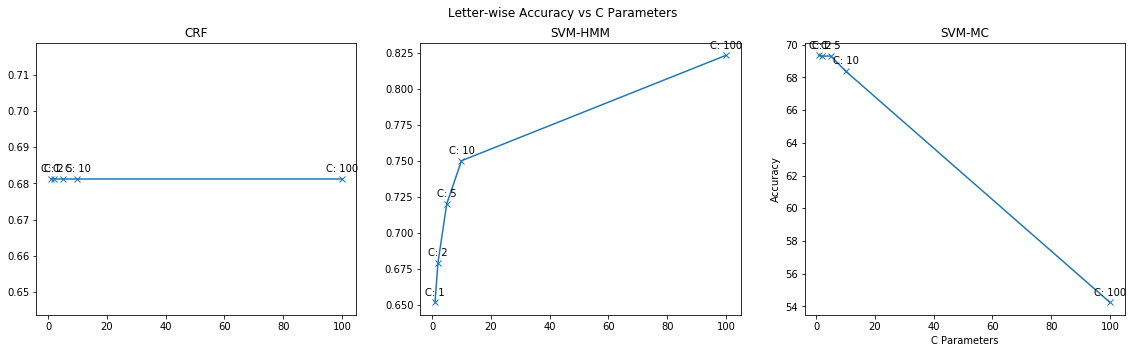

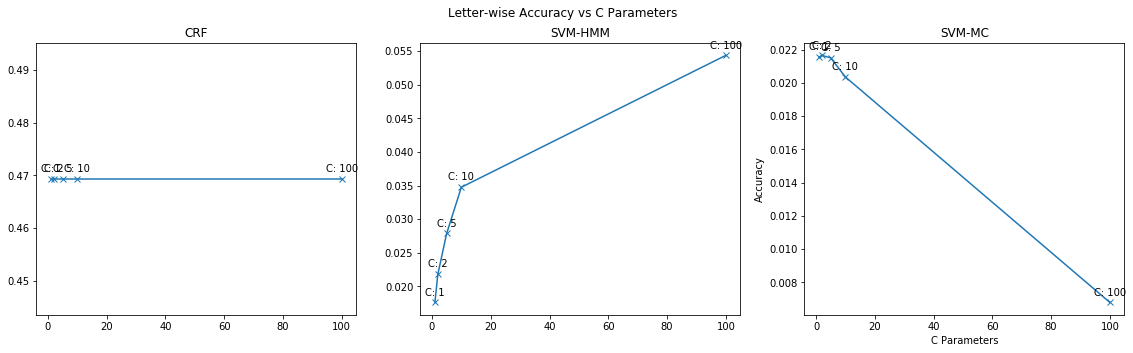

In [388]:
# Letter-wise Accuracy
plot_accuracy(cParams, acc[0,:,:], labels = ['CRF','SVM-HMM', 'SVM-MC'], title = 'Letter-wise Accuracy vs C Parameters')
# Word-wise Accuracy
plot_accuracy(cParams, acc[1,:,:], labels = ['CRF','SVM-HMM', 'SVM-MC'], title = 'Letter-wise Accuracy vs C Parameters')

# PART 4
## The evil machine learner
#### Load Indx Files, and Corruptions pattern

In [463]:
def transform_struct_to_matrix_file(inStructFile):
    """ Not Needed
    """
    outMatrixFile = os.path.join(inStructFile.rsplit('/',1)[0], inStructFile.rsplit('/',1)[1].split('.')[0] + '_matrix.txt')
    m = 0
    print("Writing conderted struct-> matrix output to {}".format(outMatrixFile))
       # with open(inStructFile,'r') as i, open(outMatrixFile,'w') as o:
    return m

# ---------------------------------------------------------------

# define rotataion translation funtiocs
def corrupt_data(data, wordIdxs, cScheme, k='all'):
    """ DESCRIPTION: Apply the corruption transformation as specified in cScheme  to data, indexed by word IDXs.
        ARGUMENTS: data(narray): Matrix holdsing the raw data; dims: numOfLetterx128
                   wordIdx(nd array): Array holding the word each letter belogns to; dims numOfLetter x 1
                   cScheme (list): A list holding the corruption transofrmations. Format is
                       r wordIdx degrees                  for rotation 
                       t word idx xTrans yTrans(optional) for translation
        RETURNS: corruptedData(nd array): The matrix holding the transformed data. DIMS: numOf letters x 128
    """
    corruptedData = np.copy(data)
    k = k if k is not 'all' else int(data.shape[0])
    # For each pixel (x, y), the output will be calculated as (ax+by+c, dx+ey+f). 
    # So if you want to apply a translation, you only have to look at the c and f values of your matrix.
    a = int(1)
    b = 0
    c = 0 #left/right (i.e. 5/-5)
    d = 0
    e = int(1)
    f = 0 #up/down (i.e. 5/-5)
    # Extract the corruption shceme
    for i,s in enumerate(cScheme[0:k]):
        tarWord = int(s[1])
        j = 0
        if s[0] == 'r': # for rotation
            for d in data[wordIdxs[tarWord-1]: wordIdxs[tarWord],:]:    
                d = d.reshape(16,8)
                img = Image.fromarray(d.astype(np.uint8))
                img = img.rotate(int(s[1])) 
                corruptedData[tarWord-1+j,:] = np.array(img).reshape(128)
                j += 1
        elif s[1] == 't': # for translation
            xTrans = int(s[2])
            yTrans = int(s[3]) if len(s) >3 else 0

            for d in data[wordIdxs[tarWord-1]: wordIdxs[tarWord],:]:    
                d = d.reshape(16,8)
                img = Image.fromarray(d.astype(np.uint8))
                img = img.rotate(s[1]) 
                img = img.transform(img.size, Image.AFFINE, (a, b, xTrans, d, e, yTrans))
                corruptedData[tarWord-1+j,:] = np.array(img).reshape(128,-1)
                j += 1
    
    return corruptedData
# --------------------------------------------------------------------------------------------------------

def save_matrix_as_structs(matrix, gTruth, savePath, k=0):
    """ DESCRIPTION: This funciton takes the input data, along with letter-wise and word-wise labels and transforms
                     them into a readable format for liblinear SVM and HMM SVM. It writes the transformed output into
                     2 separate files.
    """
    svmMcFile  = os.path.join(savePath, str(k)+'corr_liblinear_svm_train.txt')
    svmHMMFile = os.path.join(savePath, str(k)+'corr_svm_hmm_train.txt')
    crfFile    = os.path.join(savePath, str(k)+'corr_crf_train.txt') 
    # Turn and save as liblinear struct
    line  = []
    line2 = []
    line3 = []
    try:
        print("Writing: \n-> CRF train data to {}\n-> SVM-MC train data to {}\n-> HMM Train data to {}".format(crfFile,svmMcFile, svmHMMFile))
        with open(svmMcFile, 'w') as s, open(svmHMMFile, 'w') as h, open(crfFile,'w') as c:
            for i, d in enumerate(matrix): 
                #print(gTruth[i,0])
                line.append(str(gTruth[i,0])) # append label 
                line2.append(str(gTruth[i,0])) # append label 
                line2.append("qid:"+str(gTruth[i,1])) # append label 
                for j, v in enumerate(d): # append all data. Only insert non-zero vals -> sparse representation!
                    if v != 0:
                        line.append(str(j+1)+":"+str(v)) 
                        line2.append(str(int(j+1))+":"+str(int(v))) 
                        #print(line)
                line.append("\n") 
                line2.append("\n") 
                s.write(' '.join(line))
                h.write(' '.join(line2))
                line = []
                line2 = []
            filler = np.ones((matrix.shape[0],5)) * -1
            np.savetxt(c, np.append(filler,matrix,axis=1), fmt = '%d')
        return 1
    except:
        print("Failes to wrtie corrupted matrix data to files.")
        return 0
# ---------------------------------------------------------------
# Perform Train Data (Only) Tranformations - if not already done.
# Load the corruption scheme
cSchemeFile = os.path.join(dataPath, 'transform.txt')
cDataFile = os.path.join(dataPath, '0corr_liblinear_svm_train.txt')
corruptLines= [0,500,1000,1500,2000,2500]
if not os.path.exists(cDataFile):
    print("Corrupted Data files not found. Building them From Scratch!")
    with open(cSchemeFile,'r') as c, open(cDataFile, 'w') as d:
        cScheme =[x.split(' ') for x in c.read().splitlines()]   # split file into a list of lists of tokens
        # Load the data in CRF readable format
        crfTrainFile = os.path.join(dataPath, 'train.txt')
        crfTestFile  = os.path.join(dataPath, 'test.txt')
        trainD, testD = load_crf_data(crfTrainFile, crfTestFile)
        for k in corruptLines:
            print("Creating All train files (CRF, SVM-HMM, SVM-MC) with K={} corrupted lines".format(k))
            corruptedData = corrupt_data(trainD, wordIdxs, cScheme, k =  k)
            save_matrix_as_structs(corruptedData, sanTrainLabels, dataPath, k =k)
       
# ---------------------------------------------------------------
# check if values are already loaded
#try:
#    corrTrainD
#except NameError:
#        # Load the data in CRF readable format
#        crfTrainFile = os.path.join(dataPath, 'train.txt')
#        crfTestFile  = os.path.join(dataPath, 'test.txt')
#        trainD, testD = load_crf_data(crfTrainFile, crfTestFile)


Corrupted Data files not found. Building them From Scratch!
Creating All train files (CRF, SVM-HMM, SVM-MC) with K=0 corrupted lines
Writing: 
-> CRF train data to /home/nikolaos/Workspaces/AML/Assignment_1_Programming/code/../data/0corr_crf_train.txt
-> SVM-MC train data to /home/nikolaos/Workspaces/AML/Assignment_1_Programming/code/../data/0corr_liblinear_svm_train.txt
-> HMM Train data to /home/nikolaos/Workspaces/AML/Assignment_1_Programming/code/../data/0corr_svm_hmm_train.txt
Creating All train files (CRF, SVM-HMM, SVM-MC) with K=500 corrupted lines
Writing: 
-> CRF train data to /home/nikolaos/Workspaces/AML/Assignment_1_Programming/code/../data/500corr_crf_train.txt
-> SVM-MC train data to /home/nikolaos/Workspaces/AML/Assignment_1_Programming/code/../data/500corr_liblinear_svm_train.txt
-> HMM Train data to /home/nikolaos/Workspaces/AML/Assignment_1_Programming/code/../data/500corr_svm_hmm_train.txt
Creating All train files (CRF, SVM-HMM, SVM-MC) with K=1000 corrupted lines
Wr

### Evaluate Models on different K= [0:500:2500]

In [456]:
def SVM_HMM_eval(trainD, testD, learnerPath, testerPath, inLetterLabels, inWordIdxs, c = 10, label =''): 
    learnOptions = '-c ' +str(c)
    svmHmmOutput = os.path.join(dir_path,'models/svm_hmm_c_'+str(c)+label+'.model')
    ## Create a command to call the binaries required
    cmd1 = ' '.join((learnerPath, learnOptions, trainD, svmHmmOutput)) # ./svm_hmm_learn -c 5 -e 0.5 example7/declaration_of_independence.dat declaration.model 
    outFile = os.path.join(dir_path,'results/test_c_'+str(c)+label+'.outtags')
    cmdTest1 = ' '.join((testerPath, testD, svmHmmOutput, outFile)) 
    #y, x = lbl.svm_read_problem(svmTrainData, return_scipy = True) # y: ndarray, x: csr_matrix 
    #m = lbl.train(y[:200], x[:200, :], '-c 4')
    print("Executing: " ,cmd1)
    exit = os.system(cmd1) # returns the exit status
    print("Write results to ", outFile)
    print('Executing', cmdTest1)
    exit2 = os.system(cmdTest1) # returns the exit status
    print(exit, exit2)
    #ret = compute_letterwise_accuracy(outFile, gTruth = gTruth[:,0])
    pred = get_svm_hmm_results(outFile)
    letterACC, wordAcc = evaluate_predictions(pred, inLetterLabels, inWordIdxs)
    return letterAcc, wordAcc

# ------------------------------------------------------------------------
def SVM_MC_eval(trainFile, testFile, inLetterLabels, inWordIdxs, c = 10, label =''):
    """ DESCRIPTION: This function will train a model of the data contained in trainFile and test omn the data in testFile.
                     It will call upon liblinear's implementation of SVM to do multiclass (MC) chgaracter-wise classification.
                     It will return the letterwise accuracy.
    """
    wordAcc = 0
    yTrain, xTrain = lbl.svm_read_problem(trainFile, return_scipy = True) # y: ndarray, x: csr_matrix
    yTest, xTest = lbl.svm_read_problem(testFile, return_scipy = True) # y: ndarray, x: csr_matrix
    learnOptions = '-c ' +str(c/len(xTrain)) # LIBLINEAR DOES NOT divide C para by n: the numder of samples. Need to do it manually.
    outFile = 'results/liblinear-mc_c_'+str(c)+label+'.outtags' 
    model   = lbl.train(yTrain, xTrain, learnOptions)
    p_label, p_acc, p_val = lbl.predict(yTest, xTest, model)
    # Get letter and word accuracies. Returned type is a list so we need to convert to numpy array. We already have letter acc.
    _, wordAcc = evaluate_predictions(np.asarray(p_label, dtype=np.int), inLetterLabels, inWordIdxs)
        
    return p_acc[0], wordAcc, p_label   

### Evaluate CRF

In [ ]:
# ------------------------------------------------------------------------
cOpt = int(7)
accCorr = np.zeros((2,3,len(corruptLines)))
for i,k in enumerate(corruptLines[0:]):
    
    print("\nEvaluating CRF at c:{} with k= {} Corrupted lines".format(cOpt, k))
    # Load Data
    crfCorrTrainFile = os.path.join(dataPath, str(k)+'corr_crf_train.txt')
    trainD, testD = load_crf_data(crfCorrTrainFile, crfTestFile)
    # Append letter and word labels to each line (letter)
    lblCorrTrainD, lblTestD = append_label_to_crf_data(trainD, testD, sanTrainLabels, sanTestLabels)
    # Evaluate
    accCorr[0,0,i], accCorr[1,0,i] = evaluate_crf(lblCorrTrainD[0:20], lblTestD, c=cOpt, saveModelFile = None, saveAccFile = None)
    


Evaluating CRF at c:7 with k= 0 Corrupted lines
Training CRF ... c = 7 

CRF test accuracy for c: 7
Letter-wise = 0.6812352087945645
Word-Wise = 0.46932247746437916

Evaluating CRF at c:7 with k= 500 Corrupted lines
Training CRF ... c = 7 

CRF test accuracy for c: 7
Letter-wise = 0.6812352087945645
Word-Wise = 0.46932247746437916

Evaluating CRF at c:7 with k= 1000 Corrupted lines
Training CRF ... c = 7 

CRF test accuracy for c: 7
Letter-wise = 0.6812352087945645
Word-Wise = 0.46932247746437916

Evaluating CRF at c:7 with k= 1500 Corrupted lines
Training CRF ... c = 7 



### Evaluate SVM HMM

In [ ]:
for i,k in enumerate(corruptLines[0:]):
    print("Evaluating SVM HMM at c:{} with k= {} Corrupted lines".format(cOpt, k))
    svmHMMTrainFile = os.path.join(dataPath, str(k)+'corr_svm_hmm_train.txt')
    #svmHMMTrainFile = os.path.join(dataPath, 'train_struct.txt')
    svmHMMTestFile = os.path.join(dataPath, 'test_struct.txt')
    learnOptions = '-c ' +str(cOpt)
    label = '_k_'+str(k)
    #SVM_HMM_eval(svmHMMTrainFile, svmHMMTestFile, learnerPath, testerPath, sanTestLabels[:,0], c=cOpt, label = label)
    #SVM_HMM_eval(svmHMMTrainFile, svmTestData, learnerPath, testerPath, sanTestLabels[:,0], c=cOpt, label = label)
    accCorr[0, 1, i], accCorr[1, 1, i] = SVM_HMM_eval(svmHMMTrainFile, svmTestData,learnerPath, testerPath, sanTestLabels[:,0], wordTestIdxs, c=cOpt)#, label='_k_'+str(k)+'m')

Evaluating SVM HMM at c:7 with k= 0 Corrupted lines
Executing:  /home/nikolaos/Workspaces/AML/Assignment_1_Programming/code/svm_hmm_linux64/svm_hmm_learn -c 7 /home/nikolaos/Workspaces/AML/Assignment_1_Programming/code/../data/0corr_svm_hmm_train.txt /home/nikolaos/Workspaces/AML/Assignment_1_Programming/code/models/svm_hmm_c_7.model
Write results to  /home/nikolaos/Workspaces/AML/Assignment_1_Programming/code/results/test_c_7.outtags
Executing /home/nikolaos/Workspaces/AML/Assignment_1_Programming/code/svm_hmm_linux64/svm_hmm_classify /home/nikolaos/Workspaces/AML/Assignment_1_Programming/code/../data/test_struct.txt /home/nikolaos/Workspaces/AML/Assignment_1_Programming/code/models/svm_hmm_c_7.model /home/nikolaos/Workspaces/AML/Assignment_1_Programming/code/results/test_c_7.outtags
0 0
Evaluating SVM HMM at c:7 with k= 500 Corrupted lines
Executing:  /home/nikolaos/Workspaces/AML/Assignment_1_Programming/code/svm_hmm_linux64/svm_hmm_learn -c 7 /home/nikolaos/Workspaces/AML/Assignmen

### Evaluate SVM-MC (LIBLINEAR)

In [417]:
for i,k in enumerate(corruptLines[0:]):
    svmMcFile  = os.path.join(dataPath, str(k)+'corr_liblinear_svm_train.txt')
    learnOptions = '-c ' +str(cOpt)
    label = '_k_'+str(k)
    # Liblinear MC
    print("\nEvaluating SVM MC at c:{} with k = {} Corrupted lines".format(cOpt, k))
    # Evaluate and get letter and word accuracies and predicted labels (unsused)
    accCorr[0,2,i], accCorr[1,2,i], l = SVM_MC_eval(svmMcFile, libSVMTestData, sanTestLabels[:,0], wordTestIdxs, c = cOpt, label = label)


Evaluating SVM MC at c:7 with k = 0 Corrupted lines
Accuracy = 67.7189% (17741/26198) (classification)
26189
17732

Evaluating SVM MC at c:7 with k = 500 Corrupted lines
Accuracy = 66.0814% (17312/26198) (classification)
26189
17304

Evaluating SVM MC at c:7 with k = 1000 Corrupted lines
Accuracy = 65.1118% (17058/26198) (classification)
26189
17049

Evaluating SVM MC at c:7 with k = 1500 Corrupted lines
Accuracy = 64.5698% (16916/26198) (classification)
26189
16908

Evaluating SVM MC at c:7 with k = 2000 Corrupted lines
Accuracy = 64.6042% (16925/26198) (classification)
26189
16917

Evaluating SVM MC at c:7 with k = 2500 Corrupted lines
Accuracy = 64.1538% (16807/26198) (classification)
26189
16799


In [ ]:
print(np.sum(np.asarray(l) != sanTestLabels[:,0]).astype(int))
letterAcc, wordAcc = evaluate_predictions(np.asarray(l,dtype=np.int), sanTestLabels[:,0], wordTestIdxs)
print(letterAcc, wordAcc)
np.asarray(l, dtype=np.int)

### Plot All Results

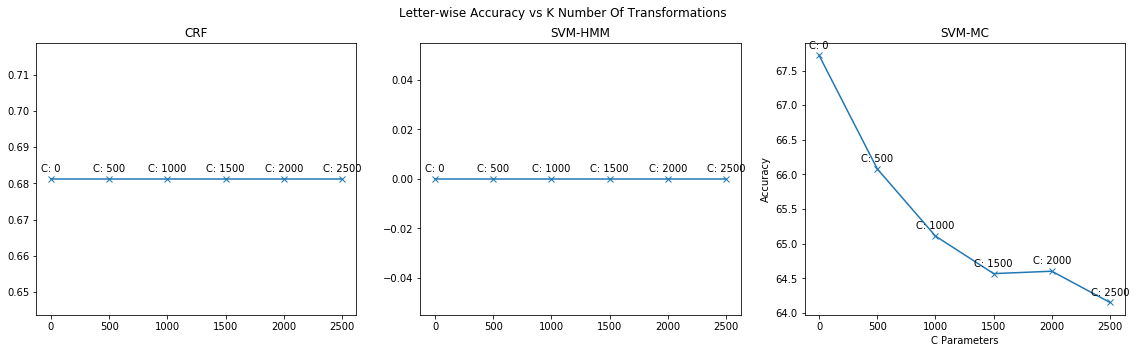

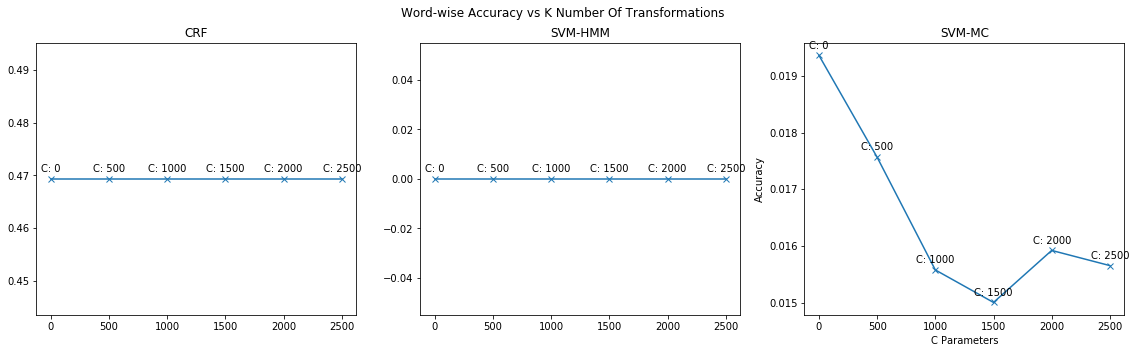

In [419]:
# Letter-wise Accuracy
plot_accuracy(corruptLines, accCorr[0,:,:], labels = ['CRF','SVM-HMM', 'SVM-MC'], title = 'Letter-wise Accuracy vs K Number Of Transformations')
# Word-wise Accuracy
plot_accuracy(corruptLines, accCorr[1,:,:], labels = ['CRF','SVM-HMM', 'SVM-MC'], title = 'Word-wise Accuracy vs K Number Of Transformations')

AttributeError: 'bool' object has no attribute 'astype'